
# Bubble Analysis

## Abstract
Analyze Hass Door part numbers of complete doors where at least one section presented a buble caused by the expansion of gas trapped between the exterior skin and foam.

## Data

Data will be imported from Microsoft Excel files in the following format:

![alt text](image.png)

The file can contain multiple sheets and all sheets will be imported and concatinated if `use_all_sheets = True`.

Columns can be added to the data by modifying `columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber', 'Order Number']`.

### Open XLSX and Convert to CSV

In [2]:
from pathlib import Path
import xlsx_to_csv as xtc

file = 'bubble_orders.xlsx'
columns = ['Line', 'Blend','EndOfPourTimeStamp', 'SmartPartNumber', 'Order Number']
overwrite_existing = False
use_all_sheets = False

# convert the XLSX file to CSV
csv_file = xtc.xls_to_csv(file, columns, overwrite_existing)

bubble_orders.csv already exists!


In [10]:
import pandas as pd
import haas_section as hs
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

print("Loading data . . .")
df = pd.read_csv(csv_file)

# disect the part number and make columns for each definition
for option, loc in hs.ht_part_number.items():
    df[option] = df['SmartPartNumber'].str[loc[0]:loc[1]]

# df.to_csv("bubbles.csv")

# # convert EndOfPourTimeStamp into date/time object
# # then make Year, Month and Day and Hour columns
df['EndOfPourTimeStamp'] = pd.to_datetime(df['EndOfPourTimeStamp'])
df['EndOfPourTimeStamp'] = df['EndOfPourTimeStamp'].dt.round(freq='15min')
df['weekday'] = df['EndOfPourTimeStamp'].dt.weekday
df['year'] = df['EndOfPourTimeStamp'].dt.year
df['month'] = df['EndOfPourTimeStamp'].dt.month
df['hour'] = df['EndOfPourTimeStamp'].dt.hour
df['time'] = df['EndOfPourTimeStamp'].dt.time
df['time'] = df['EndOfPourTimeStamp'].dt.time


df.to_csv("bubbles.csv")

# # convert EndOfPourTimeStamp into date/time object
# # then make Year, Month and Day and Hour columns
# df['Year']  = {}
# df['Month']  = {}
# df['Day of Week']  = {}
# df['Hour']  = {}
# for i, date_time in part_dict['EndOfPourTimeStamp'].items(): 
#     try:                                                
#         df['EndOfPourTimeStamp'][i] = datetime.datetime.strptime(date_time,"%Y-%m-%d %H:%M:%S")
#         df['Day of Week'][i] = df['EndOfPourTimeStamp'][i].weekday()
#         df['Month'][i] = df['EndOfPourTimeStamp'][i].month
#         df['Year'][i] = df['EndOfPourTimeStamp'][i].year
#         df['Hour'][i] = df['EndOfPourTimeStamp'][i].hour
#     except:
#         print(f'Invalid date in row {i}')


# # df = pd.DataFrame.from_dict(part_dict)

firstDate, lastDate = df['EndOfPourTimeStamp'].min(), df['EndOfPourTimeStamp'].max()
print(f'From {firstDate} to {lastDate}')

# delete the original EndOfPourTimeStamp 
df.drop('EndOfPourTimeStamp', axis=1, inplace=True)
# delete the SmartPartNumber 
df.drop('SmartPartNumber', axis=1, inplace=True)
# delete the Order Number 
df.drop('Order Number', axis=1, inplace=True)

df_shape = df.shape
df.dropna(inplace=True)
df_new_shape = df.shape

dropped_rows = df_shape[0] - df_new_shape[0]
print(f'*{dropped_rows} rows were dropped due to incomplete data.')

# remove uniform columns
uniform_columns = [col for col in df.columns if df[col].nunique() == 1]
print(str(uniform_columns) + " contain homogeneous data and have been removed.")
df = df.drop(columns=uniform_columns)

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Perform a correlation analysis using the `corr()` method
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

Loading data . . .
From 2019-10-21 22:45:00 to 2024-07-17 09:30:00
*0 rows were dropped due to incomplete data.
['Inside Grooving'] contain homogeneous data and have been removed.
                            Line     Blend      Type    Height  Construction  \
Line                    1.000000  0.004871  0.052359  0.217113      0.208281   
Blend                   0.004871  1.000000 -0.024390  0.096989      0.190824   
Type                    0.052359 -0.024390  1.000000  0.052751     -0.016853   
Height                  0.217113  0.096989  0.052751  1.000000      0.079015   
Construction            0.208281  0.190824 -0.016853  0.079015      1.000000   
Color                   0.102319 -0.111611  0.048486  0.041219     -0.241815   
Thickness              -0.260381  0.147529 -0.043084  0.122532     -0.217239   
Outside Skin           -0.268211  0.012689  0.015660 -0.229663      0.007297   
Outside Treatment       0.345905  0.131426  0.114819  0.453668      0.106580   
Outside Grooving    

The correlation matrix will contain the Pearson correlation coefficients between each pair of variables. A value closer to 1 indicates a strong positive relationship, while values closer to -1 indicate a strong negative relationship. Values close to zero suggest no linear relationship between two variables.

In [11]:
# Identify the most correlated variables
most_correlated_variables = correlation_matrix.unstack().sort_values(ascending=False)[1:]

# Print the most correlated variables
print('Most correlated variables:')
print(most_correlated_variables)

Most correlated variables:
Line                    Line                      1.000000
month                   month                     1.000000
year                    year                      1.000000
Height                  Height                    1.000000
Type                    Type                      1.000000
                                                    ...   
End Stiles              Length                   -0.298847
Length                  Backer Stile Placement   -0.348689
Backer Stile Placement  Length                   -0.348689
                        Construction             -0.483030
Construction            Backer Stile Placement   -0.483030
Length: 360, dtype: float64


<Figure size 1200x900 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Bubble Correlation Matrix Data From 10/2019 to 7/2024')

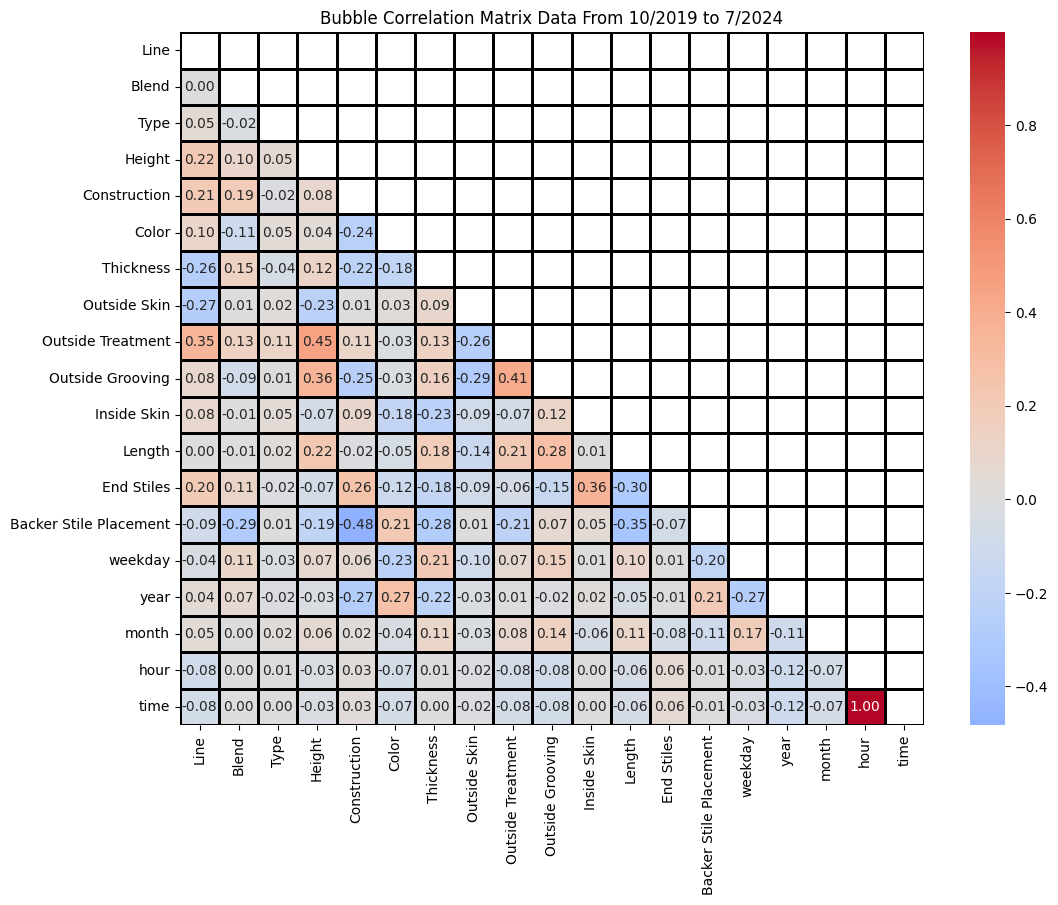

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 9))
matrix = np.triu(df.corr())
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            cbar=True, 
            fmt=".2f",
            center=0,
            linewidths=2, 
            linecolor='black',
            mask=matrix
            )

# Add a title
plt.title(f'Bubble Correlation Matrix Data From {firstDate.month}/{firstDate.year} to {lastDate.month}/{lastDate.year}')

# Show the plot
plt.show()